In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import Tensor, nn
from torch.nn import functional as F

from tomopt.core import *
from tomopt.volume import *
from tomopt.inference import *
from tomopt.muon import *
from tomopt.optimisation import *
from tomopt.plotting import *

In [3]:
DEVICE = torch.device('cpu')

<ipython-input-4-5787166f89b9>:4: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(-1, 1)


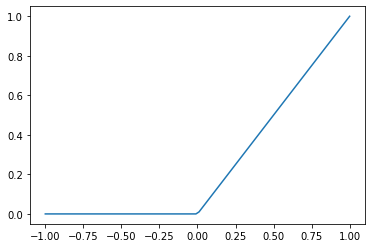

In [4]:
def area_cost(x:Tensor) -> Tensor:
    return F.relu(x)

x = torch.linspace(-1, 1)
plt.plot(x, area_cost(x))

In [5]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 1000
    n_panels = 4
    layers.append(PanelDetectorLayer(pos='above', lw=lwh[:2], z=1, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,1-(i*(2*size)/n_panels)], init_xy_span=[1.0,1.0],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))
    for z in [0.8,0.7,0.6,0.5,0.4,0.3]:
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
    layers.append(PanelDetectorLayer(pos='below', lw=lwh[:2], z=0.2, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,0.2-(i*(2*size)/n_panels)], init_xy_span=[1.0,1.0],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))

    return nn.ModuleList(layers) 

In [6]:
volume = Volume(get_layers())
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.]), and xy span tensor([1., 1.])
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9500]), and xy span tensor([1., 1.])
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9000]), and xy span tensor([1., 1.])
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.8500]), and xy span tensor([1., 1.])
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): PassiveLayer()
    (6): PassiveLayer()
    (7): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.2000]),

# Custom scatter

In [7]:
from tomopt.inference.scattering import AbsScatterBatch
from typing import *

class GenScatterBatch(AbsScatterBatch):
    def compute_tracks(self) -> None:
        self.above_hit_uncs = [torch.ones(len(self.above_gen_hits[0]),3) for _ in range(len(self.above_gen_hits))]
        self.below_hit_uncs = [torch.ones(len(self.below_gen_hits[0]),3) for _ in range(len(self.below_gen_hits))]
        self.track_in, self.track_start_in = self.get_muon_trajectory(self.above_gen_hits, self.above_hit_uncs, self.volume.lw)
        self.track_out, self.track_start_out = self.get_muon_trajectory(self.below_gen_hits, self.below_hit_uncs, self.volume.lw)


    @staticmethod
    def _compute_unc(var: Tensor, hits: List[Tensor], hit_uncs: List[Tensor]) -> Tensor:
        return var.new_zeros(var.shape)

In [8]:
muons = MuonBatch(generate_batch(100), 1)
volume.load_rad_length(VoxelPassiveGenerator().generate())
volume(muons)
sb = GenScatterBatch(muons, volume)

mom = muons.reco_mom
dtheta = sb.dtheta
theta_xy_in = sb.theta_in
theta_xy_out = sb.theta_out
        
theta2 = dtheta.pow(2).sum(1)
n_x0 = 0.5 * theta2 * ((mom / SCATTER_COEF_A) ** 2)
theta_in = theta_xy_in.pow(2).sum(1).sqrt()
theta_out = theta_xy_out.pow(2).sum(1).sqrt()
cos_theta_in = torch.cos(theta_in)
cos_theta_out = torch.cos(theta_out)
cos_mean = (cos_theta_in + cos_theta_out) / 2
pred = volume.passive_size / (n_x0 * cos_mean)

In [9]:
data = torch.cat((sb.dtheta, sb.dxy, sb.location, pred[:,None]), -1); data.shape

torch.Size([100, 8])

In [10]:
bounds = (
    volume.passive_size
    * np.mgrid[
        round(volume.get_passive_z_range()[0].detach().cpu().numpy()[0] / volume.passive_size) : round(
            volume.get_passive_z_range()[1].detach().cpu().numpy()[0] / volume.passive_size
        ) : 1,
        0 : round(volume.lw.detach().cpu().numpy()[0] / volume.passive_size) : 1,
        0 : round(volume.lw.detach().cpu().numpy()[1] / volume.passive_size) : 1,
    ]
)
int_bounds = torch.tensor(bounds.reshape(3, -1).transpose(-1, -2)) + (volume.passive_size/2)

In [11]:
int_bounds

tensor([[0.2500, 0.0500, 0.0500],
        [0.2500, 0.0500, 0.1500],
        [0.2500, 0.0500, 0.2500],
        ...,
        [0.7500, 0.9500, 0.7500],
        [0.7500, 0.9500, 0.8500],
        [0.7500, 0.9500, 0.9500]], dtype=torch.float64)

In [12]:
data = data[None,:].repeat_interleave(len(int_bounds), dim=0)

In [13]:
int_bounds = int_bounds[:,None].repeat_interleave(data.shape[1], dim=1)

In [14]:
data = torch.cat((data, int_bounds), -1)

In [15]:
data.shape

torch.Size([600, 100, 11])

In [16]:
data[0,0]

tensor([ 1.1170e-02,  8.6594e-04, -7.5732e-05,  9.7873e-04,  9.1538e-02,
         3.5124e-01,  3.4232e-01,  1.1835e-02,  2.5000e-01,  5.0000e-02,
         5.0000e-02], dtype=torch.float64, grad_fn=<SelectBackward>)

In [17]:
cube = volume.get_rad_cube(); cube.shape

torch.Size([6, 10, 10])

In [18]:
cube[0]

tensor([[0.0890, 0.0937, 0.3528, 0.3528, 0.0056, 0.0937, 0.0176, 0.0890, 0.0176,
         0.1932],
        [0.1932, 0.0937, 0.0056, 0.0890, 0.0890, 0.0176, 0.0056, 0.1932, 0.0890,
         0.0890],
        [0.0890, 0.0937, 0.3528, 0.1932, 0.1932, 0.0056, 0.0890, 0.1932, 0.1932,
         0.0176],
        [0.1932, 0.0176, 0.1932, 0.1932, 0.1932, 0.3528, 0.0144, 0.0890, 0.3528,
         0.3528],
        [0.0056, 0.0890, 0.0937, 0.3528, 0.0937, 0.0890, 0.1932, 0.0144, 0.0176,
         0.0144],
        [0.0890, 0.0937, 0.0176, 0.0890, 0.0176, 0.1932, 0.3528, 0.3528, 0.0937,
         0.0176],
        [0.0176, 0.0937, 0.0056, 0.0937, 0.0890, 0.0890, 0.3528, 0.3528, 0.1932,
         0.0937],
        [0.0890, 0.0176, 0.1932, 0.0056, 0.0890, 0.3528, 0.0937, 0.0890, 0.3528,
         0.3528],
        [0.1932, 0.0937, 0.3528, 0.0176, 0.0176, 0.1932, 0.3528, 0.0937, 0.0937,
         0.0890],
        [0.0056, 0.1932, 0.0937, 0.1932, 0.0144, 0.0144, 0.0890, 0.0937, 0.0890,
         0.0890]])

In [19]:
cube.flatten()

tensor([0.0890, 0.0937, 0.3528, 0.3528, 0.0056, 0.0937, 0.0176, 0.0890, 0.0176,
        0.1932, 0.1932, 0.0937, 0.0056, 0.0890, 0.0890, 0.0176, 0.0056, 0.1932,
        0.0890, 0.0890, 0.0890, 0.0937, 0.3528, 0.1932, 0.1932, 0.0056, 0.0890,
        0.1932, 0.1932, 0.0176, 0.1932, 0.0176, 0.1932, 0.1932, 0.1932, 0.3528,
        0.0144, 0.0890, 0.3528, 0.3528, 0.0056, 0.0890, 0.0937, 0.3528, 0.0937,
        0.0890, 0.1932, 0.0144, 0.0176, 0.0144, 0.0890, 0.0937, 0.0176, 0.0890,
        0.0176, 0.1932, 0.3528, 0.3528, 0.0937, 0.0176, 0.0176, 0.0937, 0.0056,
        0.0937, 0.0890, 0.0890, 0.3528, 0.3528, 0.1932, 0.0937, 0.0890, 0.0176,
        0.1932, 0.0056, 0.0890, 0.3528, 0.0937, 0.0890, 0.3528, 0.3528, 0.1932,
        0.0937, 0.3528, 0.0176, 0.0176, 0.1932, 0.3528, 0.0937, 0.0937, 0.0890,
        0.0056, 0.1932, 0.0937, 0.1932, 0.0144, 0.0144, 0.0890, 0.0937, 0.0890,
        0.0890, 0.0890, 0.0176, 0.0144, 0.0890, 0.0056, 0.3528, 0.0144, 0.1932,
        0.0937, 0.3528, 0.3528, 0.0890, 

In [20]:
from tomopt.optimisation.data.passives import AbsPassiveGenerator

from lumin.nn.data.fold_yielder import FoldYielder

class ScatterYielder(FoldYielder):
    def __init__(self, volume:Volume, passive_generator:AbsPassiveGenerator, mu_bs:int, n_volumes_per_fold:int, materials:Optional[List[str]]=None):
        self.cont_feats,self.cat_feats,self.input_pipe,self.output_pipe = [],[],None,None
        self.yield_matrix,self.matrix_pipe = True,None
        self.augmented,self.aug_mult,self.train_time_aug,self.test_time_aug = False,0,False,False
        self.input_feats = self.cont_feats + self.cat_feats
        self.orig_cont_feats,self.orig_cat_feat,self._ignore_feats = self.cont_feats,self.cat_feats,[]
        
        self.volume,self.passive_generator,self.mu_bs = volume,passive_generator,mu_bs
        self.voxel_centres = self._build_centres()
        if materials is None:
            materials = [m for m in X0]
        self.materials = materials
        
        self.n_volumes_per_fold = n_volumes_per_fold
        self.n_voxels = int(len(self.volume.get_passives())*(self.volume.lw/self.volume.passive_size).prod().item())
        self.n_folds = 10
        self.has_matrix = True
        self.fld_szs = {i:self.n_volumes_per_fold*self.n_voxels for i in range(self.n_folds)}
        
        self.targ_feats = ["X0"]
        self.matrix_feats = {'present_feats': ["dtheta_x", "dtheta_y", "dx", "dy", "poca_x", "poca_y", "poca_z", "pred_x0", "vox_z", "vox_x", "vox_y"], 'vecs': [f'mu_{i}' for i in range(self.mu_bs)], 'missing': [],
                             'feats_per_vec': 11, 'row_wise': True, 'shape': (self.mu_bs, 11)}
        self.matrix_is_sparse = False
        self.matrix_shape = self.matrix_feats['shape']
        
    def _build_centres(self) -> Tensor:
        bounds = (
            self.volume.passive_size
            * np.mgrid[
                round(self.volume.get_passive_z_range()[0].detach().cpu().numpy()[0] / self.volume.passive_size) : round(
                      self.volume.get_passive_z_range()[1].detach().cpu().numpy()[0] / self.volume.passive_size
                ) : 1,
                0 : round(self.volume.lw.detach().cpu().numpy()[0] / self.volume.passive_size) : 1,
                0 : round(self.volume.lw.detach().cpu().numpy()[1] / self.volume.passive_size) : 1,
            ]
        )
#         bounds[0] = np.flip(bounds[0])  # z is reversed
        voxel_centres = torch.tensor(bounds.reshape(3, -1).transpose(-1, -2)) + (self.volume.passive_size/2)
        return voxel_centres[:,None].repeat_interleave(self.mu_bs, dim=1)
        
    def generate_data(self) -> Dict[str, np.ndarray]:
        inputs,targets = [],[]
        for _ in range(self.n_volumes_per_fold):
            #Scatter generation
            muons = MuonBatch(generate_batch(self.mu_bs), self.volume.h, device=self.volume.device)
            self.volume.load_rad_length(self.passive_generator.generate())
            self.volume(muons)
            sb = GenScatterBatch(muons, self.volume)
            
            # x0 prediction
            mom = muons.reco_mom
            dtheta = sb.dtheta
            theta_xy_in = sb.theta_in
            theta_xy_out = sb.theta_out
            theta2 = dtheta.pow(2).sum(1)
            n_x0 = 0.5 * theta2 * ((mom / SCATTER_COEF_A) ** 2)
            theta_in = theta_xy_in.pow(2).sum(1).sqrt()
            theta_out = theta_xy_out.pow(2).sum(1).sqrt()
            cos_theta_in = torch.cos(theta_in)
            cos_theta_out = torch.cos(theta_out)
            cos_mean = (cos_theta_in + cos_theta_out) / 2
            pred = self.volume.passive_size / (n_x0 * cos_mean)
            
            #Data creation
            data = torch.cat((sb.dtheta, sb.dxy, sb.location, pred[:,None]), dim=-1).detach()
            data = data[None,:].repeat_interleave(len(self.voxel_centres), dim=0)
            inputs.append(torch.cat((data, self.voxel_centres), -1))
            targets.append(self.volume.get_rad_cube().flatten())c
        
        inputs = torch.cat(inputs, dim=0).detach().cpu().numpy()
        return {'inputs':(np.zeros((len(inputs),0)),inputs),'targets':torch.cat(targets, dim=0).detach().cpu().numpy()[:,None]}
        
    def get_fold(self, idx:int) -> Dict[str,np.ndarray]:
        return self.generate_data()

In [21]:
sy = ScatterYielder(volume=volume, passive_generator=VoxelPassiveGenerator(), mu_bs=100, n_volumes_per_fold=2)

In [22]:
sy.n_voxels

600

In [23]:
fold = sy[0]
fold['inputs'][1].shape
fold['targets'].shape

(1200, 1)

# GravNet

In [78]:
from lumin.nn.models.blocks.head import GNNHead, GraphCollapser
from lumin.nn.models.blocks.gnn_blocks import GravNet
from lumin.nn.models.blocks.body import FullyConnected
from lumin.nn.models.blocks.tail import ClassRegMulti

from lumin.nn.models.model_builder import ModelBuilder
from lumin.nn.models.model import Model
from lumin.nn.models.layers.batchnorms import RunningBatchNorm1d

head = partial(GNNHead, vecs=sy.matrix_feats['vecs'], feats_per_vec=sy.matrix_feats['present_feats'],
               extractor=partial(GravNet,
                                 cat_means=True,
                                 f_slr_depth=3,
                                 n_s=4,
                                 n_lr=22,
                                 k=10,
                                 f_out_depth=1,
                                 n_out=[48],
                                 act='swish',
                                 bn=True),
               collapser=partial(GraphCollapser,
                                 flatten=False,
                                 f_final_outs=[40],
                                 act='swish'))

body = partial(FullyConnected, depth=3, width=50, act='swish')
opt_args = {'opt':'adam', 'eps':1e-08}
tail = partial(ClassRegMulti, bias_init=np.mean([v for v in X0.values()]))
model_builder = ModelBuilder('regression', cont_feats=sy.matrix_feats['present_feats'], n_out=1, 
                             opt_args=opt_args, body=body, head=head, tail=tail)
print(Model(model_builder))

Inputs:
11 Continuous: ['dtheta_x', 'dtheta_y', 'dx', 'dy', 'poca_x', 'poca_y', 'poca_z', 'pred_x0', 'vox_z', 'vox_x', 'vox_y']
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): GNNHead(
    (extractor): GravNet(
      (grav_layers): ModuleList(
        (0): GravNetLayer(
          (f_slr): Sequential(
            (0): Sequential(
              (0): Linear(in_features=22, out_features=30, bias=True)
              (1): Swish()
              (2): LCBatchNorm1d(
                (bn): RunningBatchNorm1d()
              )
            )
            (1): Sequential(
              (0): Linear(in_features=30, out_features=30, bias=True)
              (1): Swish()
              (2): LCBatchNorm1d(
                (bn): RunningBatchNorm1d()
              )
            )
            (2): Sequential(
              (0): Linear(in_features=30, out_features=26, bias=True)
              (1)

In [79]:
model = Model(model_builder)

In [63]:
x = Tensor(fold['inputs'][1])

In [64]:
x.shape

torch.Size([1200, 100, 11])

In [65]:
pred = model.model(x)

In [66]:
pred

tensor([[ 0.3171],
        [ 0.3187],
        [ 0.3204],
        ...,
        [17.6090],
        [17.6090],
        [17.6090]], grad_fn=<AddmmBackward>)

In [67]:
pred.shape

torch.Size([1200, 1])

In [68]:
from lumin.optimisation.hyper_param import lr_find

LR finder took 32.258s 


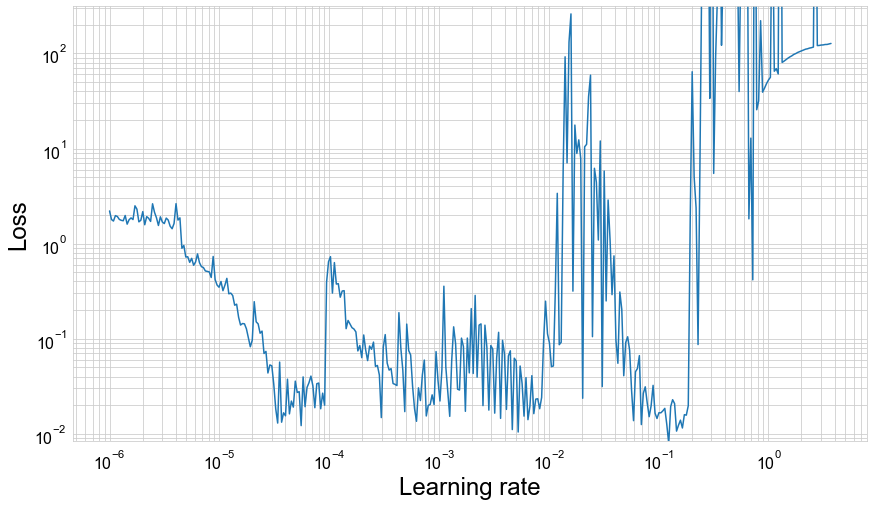

In [70]:
lr_finder = lr_find(sy, model_builder, bs=32, lr_bounds=[1e-6,1e0], n_folds=1)

LR finder took 325.161s 


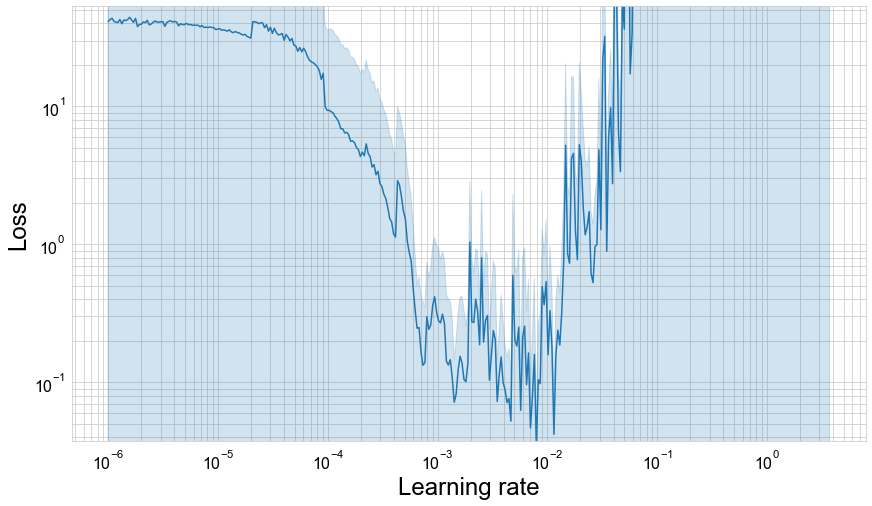

In [71]:
lr_finder = lr_find(sy, model_builder, bs=32, lr_bounds=[1e-6,1e0], n_folds=10)

In [72]:
from lumin.nn.callbacks.cyclic_callbacks import OneCycle
from functools import partial

cb_partials = [partial(OneCycle, lengths=[5, 10],lr_range=[1e-5, 1e-3], mom_range=[0.85, 0.95], interp='cosine')]

Training model 1 / 1, Valid Index = 0, Train indices= [1, 2, 3, 4, 5, 6, 7, 8, 9]


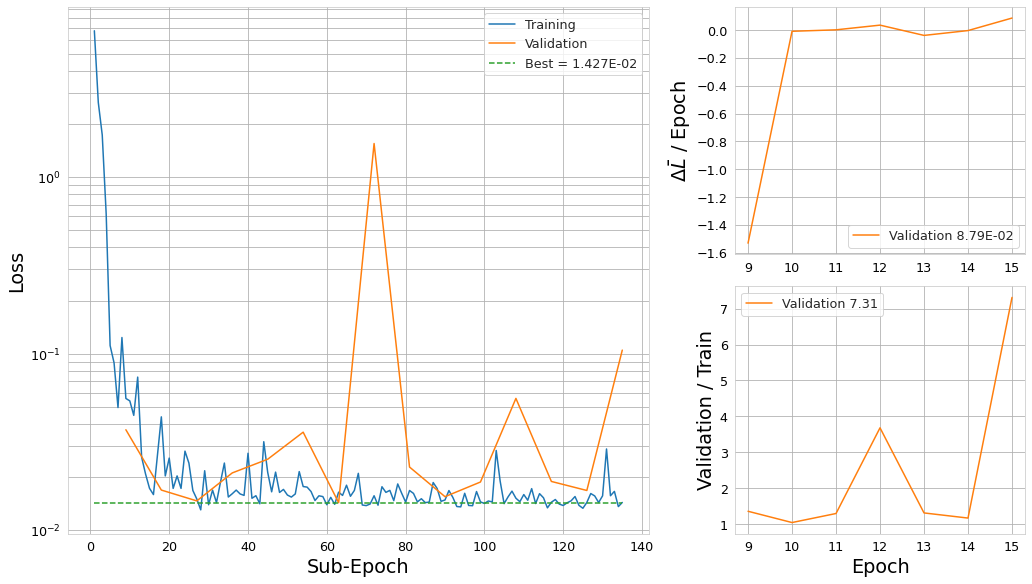

Loading best model with metric value 1.427E-02
Model took 474.725s

Scores are: {'loss': 0.014271114952862263}

______________________________________
Training finished
Cross-validation took 474.785s 


<Figure size 1024x576 with 0 Axes>

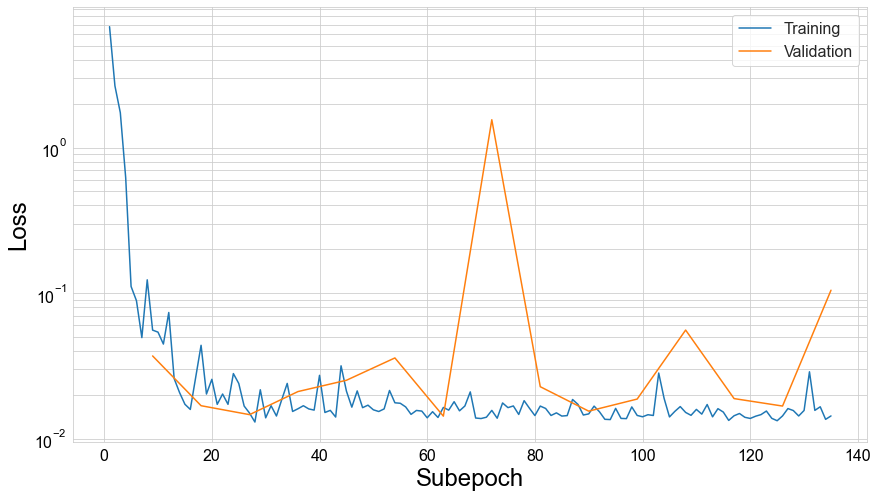

Mean loss = 0.014271114952862263±0.0
______________________________________



In [73]:
from lumin.nn.training.train import train_models
_ = train_models(sy, n_models=1,
                 model_builder=model_builder,
                 bs=32,
                 cb_partials=cb_partials,
                 n_epochs=15)

Training model 1 / 1, Valid Index = 0, Train indices= [1, 2, 3, 4, 5, 6, 7, 8, 9]


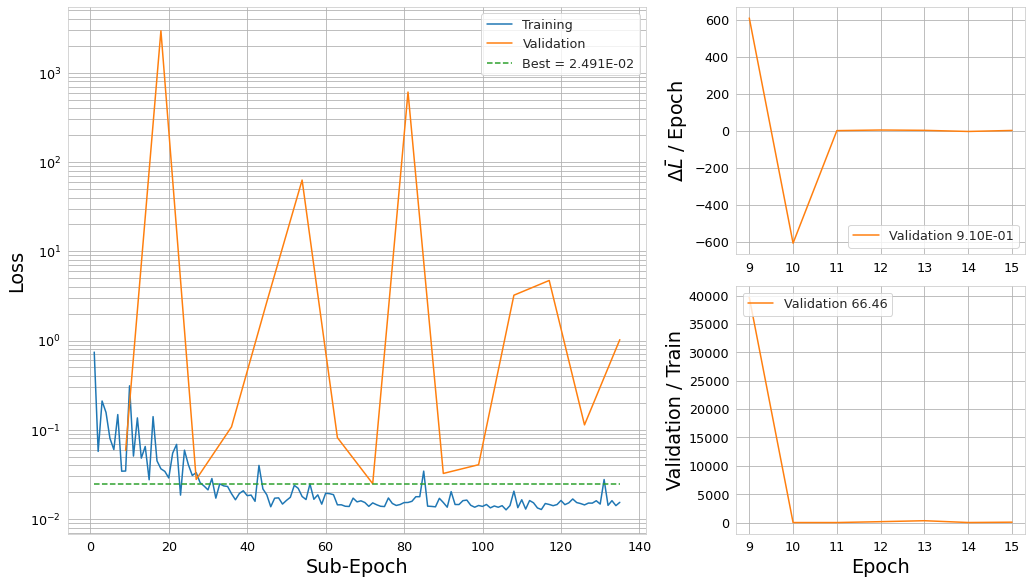

Loading best model with metric value 2.491E-02
Model took 478.961s

Scores are: {'loss': 0.024913540109992027}

______________________________________
Training finished
Cross-validation took 479.023s 


<Figure size 1024x576 with 0 Axes>

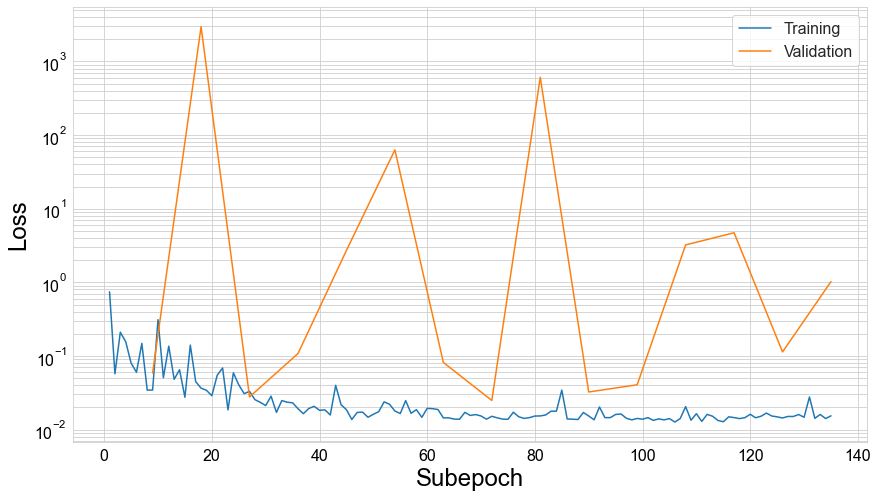

Mean loss = 0.024913540109992027±0.0
______________________________________



In [80]:
from lumin.nn.training.train import train_models
_ = train_models(sy, n_models=1,
                 model_builder=model_builder,
                 bs=32,
                 cb_partials=cb_partials,
                 n_epochs=15)

In [81]:
model = Model.from_save('train_weights/model_id_0/train_0.h5', model_builder)

In [82]:
pred = model.model(x)

In [83]:
pred.unique()

tensor([0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731,
        0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731,
        0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731,
        0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731,
        0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731,
        0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731,
        0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731,
        0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731,
        0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731,
        0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731,
        0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731,
        0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731, 0.0731,
        0.0731, 0.0731, 0.0731, 0.0731, 

In [77]:
fold['targets'].mean()

0.10269489

# Classifier

In [101]:
from tomopt.optimisation.data.passives import AbsPassiveGenerator

from lumin.nn.data.fold_yielder import FoldYielder

class ScatterYielder(FoldYielder):
    def __init__(self, volume:Volume, passive_generator:AbsPassiveGenerator, mu_bs:int, n_volumes_per_fold:int, targ_as_class:bool):
        self.cont_feats,self.cat_feats,self.input_pipe,self.output_pipe = [],[],None,None
        self.yield_matrix,self.matrix_pipe = True,None
        self.augmented,self.aug_mult,self.train_time_aug,self.test_time_aug = False,0,False,False
        self.input_feats = self.cont_feats + self.cat_feats
        self.orig_cont_feats,self.orig_cat_feat,self._ignore_feats = self.cont_feats,self.cat_feats,[]
        
        self.volume,self.passive_generator,self.mu_bs = volume,passive_generator,mu_bs
        self.voxel_centres = self._build_centres()
        self.targ_as_class = targ_as_class
        if self.targ_as_class:
            self.class2id = {m:i for i,m in enumerate(self.passive_generator.materials)}
            self.id2class = {i:m for i,m in enumerate(self.passive_generator.materials)}
            self.x02id = {X0[m]:i for i,m in enumerate(self.passive_generator.materials)}
            self.id2x0 = {i:X0[m] for i,m in enumerate(self.passive_generator.materials)}
                
        self.n_volumes_per_fold = n_volumes_per_fold
        self.n_voxels = int(len(self.volume.get_passives())*(self.volume.lw/self.volume.passive_size).prod().item())
        self.n_folds = 10
        self.has_matrix = True
        self.fld_szs = {i:self.n_volumes_per_fold*self.n_voxels for i in range(self.n_folds)}
        
        self.targ_feats = ["X0"]
        self.matrix_feats = {'present_feats': ["dtheta_x", "dtheta_y", "dx", "dy", "poca_x", "poca_y", "poca_z", "pred_x0", "vox_z", "vox_x", "vox_y"], 'vecs': [f'mu_{i}' for i in range(self.mu_bs)], 'missing': [],
                             'feats_per_vec': 11, 'row_wise': True, 'shape': (self.mu_bs, 11)}
        self.matrix_is_sparse = False
        self.matrix_shape = self.matrix_feats['shape']
        
    def _build_centres(self) -> Tensor:
        bounds = (
            self.volume.passive_size
            * np.mgrid[
                round(self.volume.get_passive_z_range()[0].detach().cpu().numpy()[0] / self.volume.passive_size) : round(
                      self.volume.get_passive_z_range()[1].detach().cpu().numpy()[0] / self.volume.passive_size
                ) : 1,
                0 : round(self.volume.lw.detach().cpu().numpy()[0] / self.volume.passive_size) : 1,
                0 : round(self.volume.lw.detach().cpu().numpy()[1] / self.volume.passive_size) : 1,
            ]
        )
#         bounds[0] = np.flip(bounds[0])  # z is reversed
        voxel_centres = torch.tensor(bounds.reshape(3, -1).transpose(-1, -2)) + (self.volume.passive_size/2)
        return voxel_centres[:,None].repeat_interleave(self.mu_bs, dim=1)
        
    def generate_data(self) -> Dict[str, np.ndarray]:
        inputs,targets = [],[]
        for _ in range(self.n_volumes_per_fold):
            #Scatter generation
            muons = MuonBatch(generate_batch(self.mu_bs), self.volume.h, device=self.volume.device)
            self.volume.load_rad_length(self.passive_generator.generate())
            self.volume(muons)
            sb = GenScatterBatch(muons, self.volume)
            
            # x0 prediction
            mom = muons.reco_mom
            dtheta = sb.dtheta
            theta_xy_in = sb.theta_in
            theta_xy_out = sb.theta_out
            theta2 = dtheta.pow(2).sum(1)
            n_x0 = 0.5 * theta2 * ((mom / SCATTER_COEF_A) ** 2)
            theta_in = theta_xy_in.pow(2).sum(1).sqrt()
            theta_out = theta_xy_out.pow(2).sum(1).sqrt()
            cos_theta_in = torch.cos(theta_in)
            cos_theta_out = torch.cos(theta_out)
            cos_mean = (cos_theta_in + cos_theta_out) / 2
            pred = self.volume.passive_size / (n_x0 * cos_mean)
            
            #Data creation
            data = torch.cat((sb.dtheta, sb.dxy, sb.location, pred[:,None]), dim=-1).detach()
            data = data[None,:].repeat_interleave(len(self.voxel_centres), dim=0)
            inputs.append(torch.cat((data, self.voxel_centres), -1))
            targets.append(self.volume.get_rad_cube().flatten())
        
        inputs = torch.cat(inputs, dim=0).detach().cpu().numpy()
        targets = torch.cat(targets, dim=0).detach().cpu().numpy()[:,None]
        if self.targ_as_class:
            for m in self.passive_generator.materials:
                targets[targets == X0[m]] = self.class2id[m]
            targets = targets.astype(int)
        return {'inputs':(np.zeros((len(inputs),0)),inputs),'targets':targets}
        
    def get_fold(self, idx:int) -> Dict[str,np.ndarray]:
        return self.generate_data()

In [102]:
sy = ScatterYielder(volume=volume, passive_generator=VoxelPassiveGenerator(), mu_bs=100, targ_as_class=True, n_volumes_per_fold=2)

In [103]:
sy.n_voxels

600

In [104]:
fold = sy[0]
fold['inputs'][1].shape
fold['targets'].shape

(1200, 1)

In [105]:
fold['targets']

array([[4],
       [6],
       [0],
       ...,
       [0],
       [5],
       [1]])

In [106]:
from lumin.nn.models.blocks.head import GNNHead, GraphCollapser
from lumin.nn.models.blocks.gnn_blocks import GravNet
from lumin.nn.models.blocks.body import FullyConnected
from lumin.nn.models.blocks.tail import ClassRegMulti

from lumin.nn.models.model_builder import ModelBuilder
from lumin.nn.models.model import Model
from lumin.nn.models.layers.batchnorms import RunningBatchNorm1d

head = partial(GNNHead, vecs=sy.matrix_feats['vecs'], feats_per_vec=sy.matrix_feats['present_feats'],
               extractor=partial(GravNet,
                                 cat_means=True,
                                 f_slr_depth=3,
                                 n_s=4,
                                 n_lr=22,
                                 k=10,
                                 f_out_depth=1,
                                 n_out=[48],
                                 act='swish',
                                 bn=True),
               collapser=partial(GraphCollapser,
                                 flatten=False,
                                 f_final_outs=[40],
                                 act='swish'))

body = partial(FullyConnected, depth=3, width=50, act='swish')
opt_args = {'opt':'adam', 'eps':1e-08}
model_builder = ModelBuilder('multiclass', cont_feats=sy.matrix_feats['present_feats'], n_out=len(sy.passive_generator.materials), 
                             opt_args=opt_args, body=body, head=head, tail=tail)
print(Model(model_builder))

Inputs:
11 Continuous: ['dtheta_x', 'dtheta_y', 'dx', 'dy', 'poca_x', 'poca_y', 'poca_z', 'pred_x0', 'vox_z', 'vox_x', 'vox_y']
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): GNNHead(
    (extractor): GravNet(
      (grav_layers): ModuleList(
        (0): GravNetLayer(
          (f_slr): Sequential(
            (0): Sequential(
              (0): Linear(in_features=22, out_features=30, bias=True)
              (1): Swish()
              (2): LCBatchNorm1d(
                (bn): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
            )
            (1): Sequential(
              (0): Linear(in_features=30, out_features=30, bias=True)
              (1): Swish()
              (2): LCBatchNorm1d(
                (bn): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
            

LR finder took 33.814s 


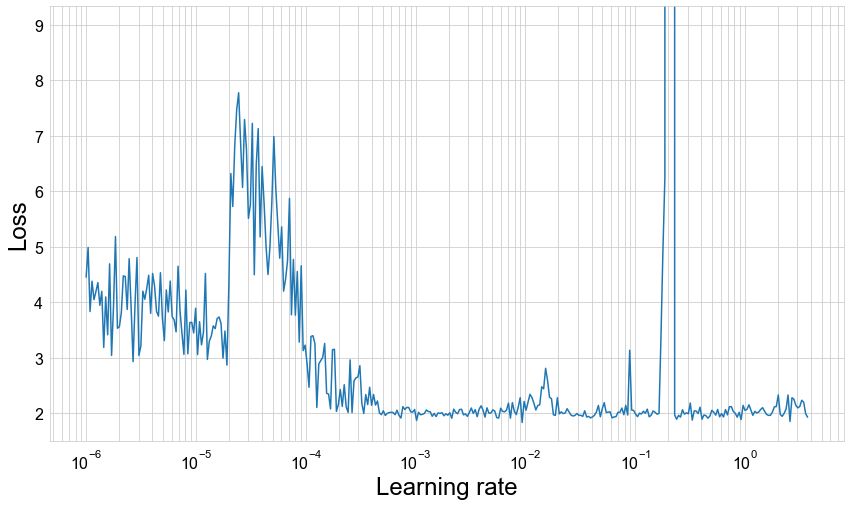

In [107]:
lr_finder = lr_find(sy, model_builder, bs=32, lr_bounds=[1e-6,1e0], n_folds=1)

LR finder took 350.707s 


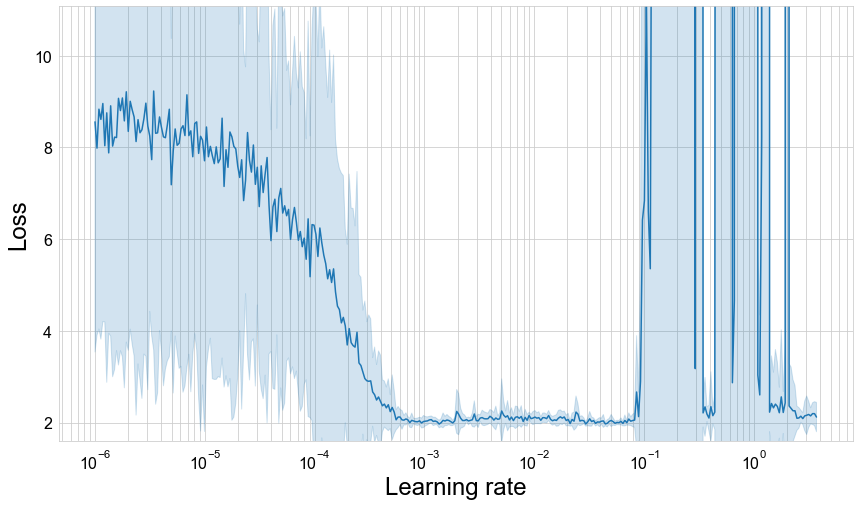

In [108]:
lr_finder = lr_find(sy, model_builder, bs=32, lr_bounds=[1e-6,1e0], n_folds=10)

In [109]:
from lumin.nn.callbacks.cyclic_callbacks import OneCycle
from functools import partial

cb_partials = [partial(OneCycle, lengths=[5, 10],lr_range=[1e-5, 1e-3], mom_range=[0.85, 0.95], interp='cosine')]

Training model 1 / 1, Valid Index = 0, Train indices= [1, 2, 3, 4, 5, 6, 7, 8, 9]


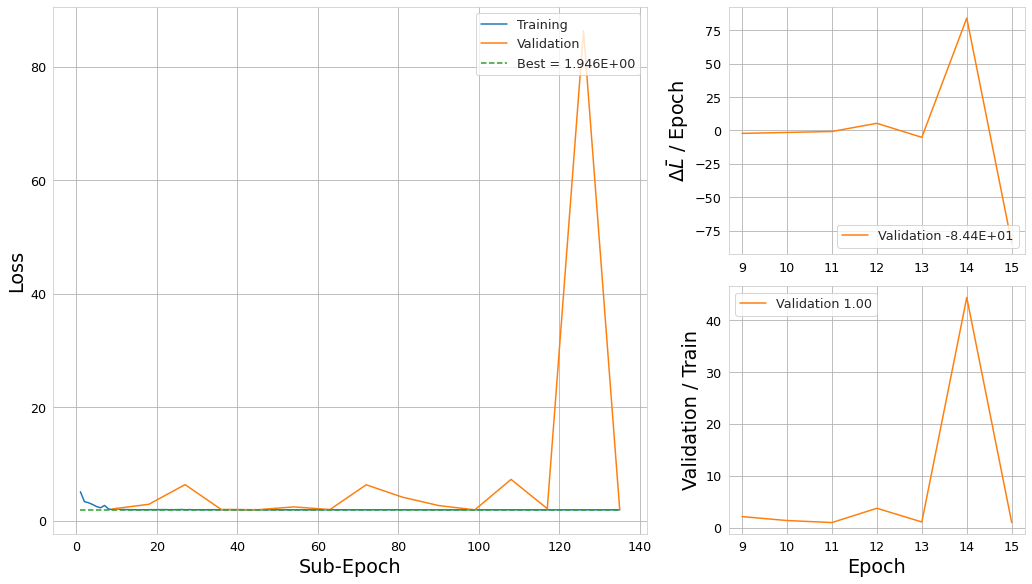

Loading best model with metric value 1.946E+00
Model took 514.390s

Scores are: {'loss': 1.9456332921981812}

______________________________________
Training finished
Cross-validation took 514.449s 


<Figure size 1024x576 with 0 Axes>

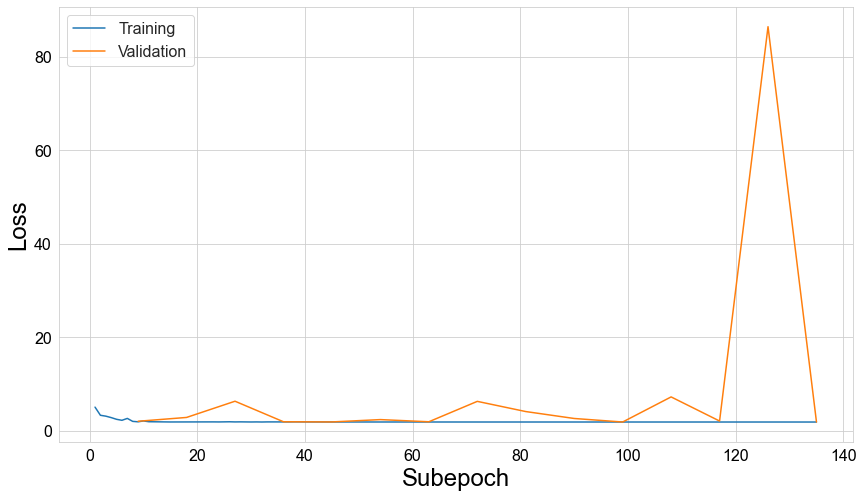

Mean loss = 1.9456332921981812±0.0
______________________________________



In [110]:
from lumin.nn.training.train import train_models
_ = train_models(sy, n_models=1,
                 model_builder=model_builder,
                 bs=32,
                 cb_partials=cb_partials,
                 n_epochs=15)

In [111]:
model = Model.from_save('train_weights/model_id_0/train_0.h5', model_builder)

In [126]:
data = sy[0]

In [128]:
pred = model.model(Tensor(data['inputs'][1]))

In [129]:
pred

tensor([[-1.9209, -2.0653, -1.9904,  ..., -1.9304, -1.8596, -1.9799],
        [-1.9209, -2.0652, -1.9904,  ..., -1.9303, -1.8597, -1.9802],
        [-1.9208, -2.0651, -1.9904,  ..., -1.9303, -1.8598, -1.9804],
        ...,
        [-1.9293, -1.9091, -2.0147,  ..., -1.9391, -1.9481, -1.9499],
        [-1.9296, -1.9096, -2.0138,  ..., -1.9384, -1.9478, -1.9518],
        [-1.9298, -1.9101, -2.0131,  ..., -1.9378, -1.9475, -1.9537]],
       grad_fn=<LogSoftmaxBackward>)

In [143]:
pred.argmax(-1).unique()

tensor([1, 5])

In [132]:
pred_class = pred.argmax(-1).numpy()

In [136]:
targs = data['targets'].flatten()

In [142]:
pred_class

array([5, 5, 5, ..., 1, 1, 1])

In [138]:
targs

array([0, 4, 2, ..., 5, 3, 0])

In [139]:
from sklearn.metrics import confusion_matrix

In [140]:
confusion_matrix(targs, pred_class)

array([[ 0, 85,  0,  0,  0, 86,  0],
       [ 0, 98,  0,  0,  0, 82,  0],
       [ 0, 86,  0,  0,  0, 93,  0],
       [ 0, 90,  0,  0,  0, 89,  0],
       [ 0, 81,  0,  0,  0, 70,  0],
       [ 0, 71,  0,  0,  0, 93,  0],
       [ 0, 89,  0,  0,  0, 87,  0]])

# Two classes

In [144]:
sy = ScatterYielder(volume=volume, passive_generator=VoxelPassiveGenerator(materials=['beryllium', 'lead']), mu_bs=100, targ_as_class=True, n_volumes_per_fold=2)

In [145]:
sy.n_voxels

600

In [146]:
fold = sy[0]
fold['inputs'][1].shape
fold['targets'].shape

(1200, 1)

In [147]:
fold['targets']

array([[0],
       [0],
       [1],
       ...,
       [0],
       [1],
       [0]])

In [155]:
from lumin.nn.models.blocks.head import GNNHead, GraphCollapser
from lumin.nn.models.blocks.gnn_blocks import GravNet
from lumin.nn.models.blocks.body import FullyConnected
from lumin.nn.models.blocks.tail import ClassRegMulti

from lumin.nn.models.model_builder import ModelBuilder
from lumin.nn.models.model import Model
from lumin.nn.models.layers.batchnorms import RunningBatchNorm1d

head = partial(GNNHead, vecs=sy.matrix_feats['vecs'], feats_per_vec=sy.matrix_feats['present_feats'],
               extractor=partial(GravNet,
                                 cat_means=True,
                                 f_slr_depth=3,
                                 n_s=4,
                                 n_lr=22,
                                 k=10,
                                 f_out_depth=1,
                                 n_out=[48],
                                 act='swish',
                                 bn=True),
               collapser=partial(GraphCollapser,
                                 flatten=False,
                                 f_final_outs=[40],
                                 act='swish'))

body = partial(FullyConnected, depth=3, width=50, act='swish')
opt_args = {'opt':'adam', 'eps':1e-08}
model_builder = ModelBuilder('multiclass', cont_feats=sy.matrix_feats['present_feats'], n_out=len(sy.passive_generator.materials), 
                             opt_args=opt_args, body=body, head=head, tail=tail)
print(Model(model_builder))

Inputs:
11 Continuous: ['dtheta_x', 'dtheta_y', 'dx', 'dy', 'poca_x', 'poca_y', 'poca_z', 'pred_x0', 'vox_z', 'vox_x', 'vox_y']
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): GNNHead(
    (extractor): GravNet(
      (grav_layers): ModuleList(
        (0): GravNetLayer(
          (f_slr): Sequential(
            (0): Sequential(
              (0): Linear(in_features=22, out_features=30, bias=True)
              (1): Swish()
              (2): LCBatchNorm1d(
                (bn): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
            )
            (1): Sequential(
              (0): Linear(in_features=30, out_features=30, bias=True)
              (1): Swish()
              (2): LCBatchNorm1d(
                (bn): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
            

LR finder took 37.529s 


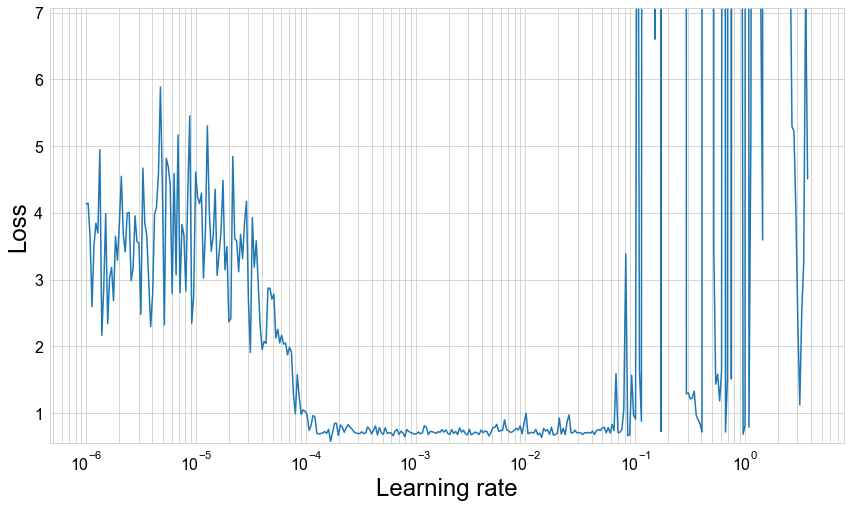

In [149]:
lr_finder = lr_find(sy, model_builder, bs=32, lr_bounds=[1e-6,1e0], n_folds=1)

LR finder took 350.707s 


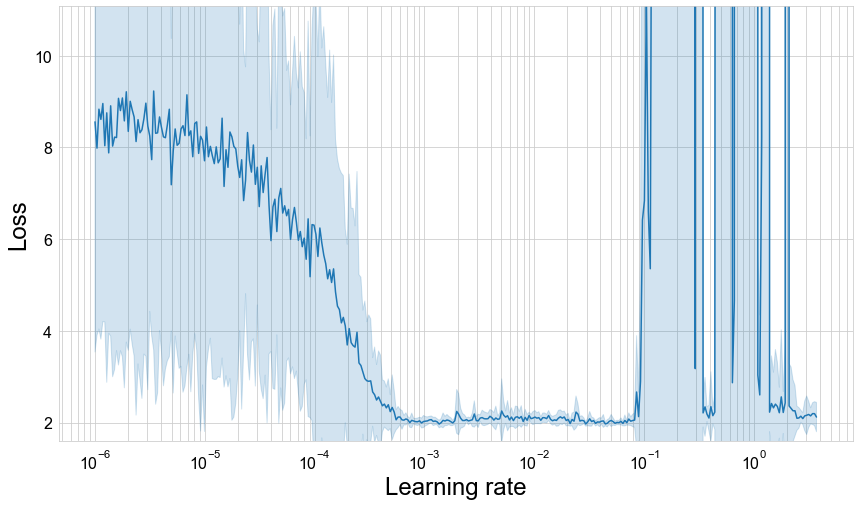

In [108]:
lr_finder = lr_find(sy, model_builder, bs=32, lr_bounds=[1e-6,1e0], n_folds=10)

In [156]:
from lumin.nn.callbacks.cyclic_callbacks import OneCycle
from functools import partial

cb_partials = [partial(OneCycle, lengths=[5, 10],lr_range=[1e-5, 1e-3], mom_range=[0.85, 0.95], interp='cosine')]

Training model 1 / 1, Valid Index = 0, Train indices= [1, 2, 3, 4, 5, 6, 7, 8, 9]


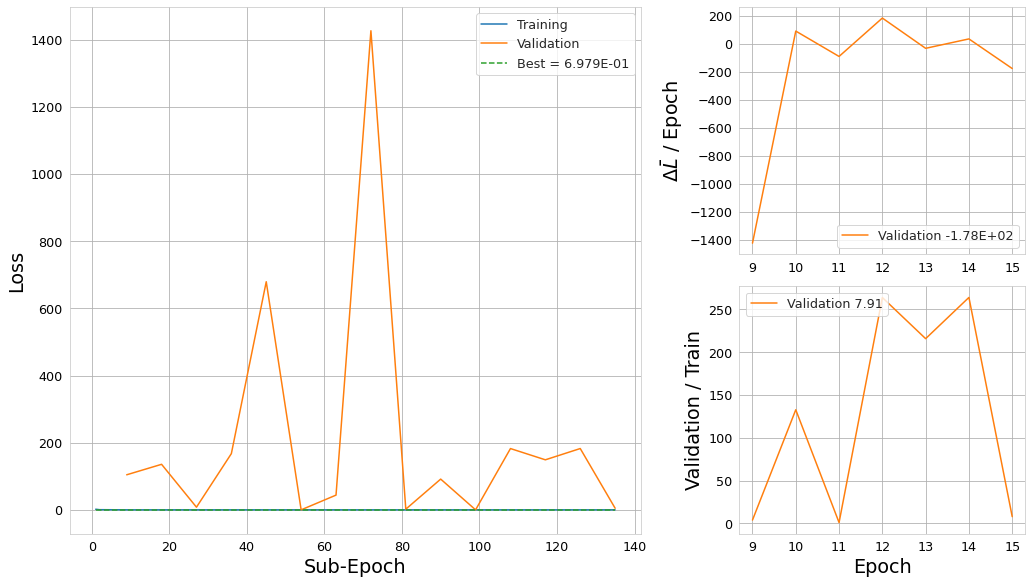

Loading best model with metric value 6.979E-01
Model took 498.567s

Scores are: {'loss': 0.6978845596313477}

______________________________________
Training finished
Cross-validation took 498.650s 


<Figure size 1024x576 with 0 Axes>

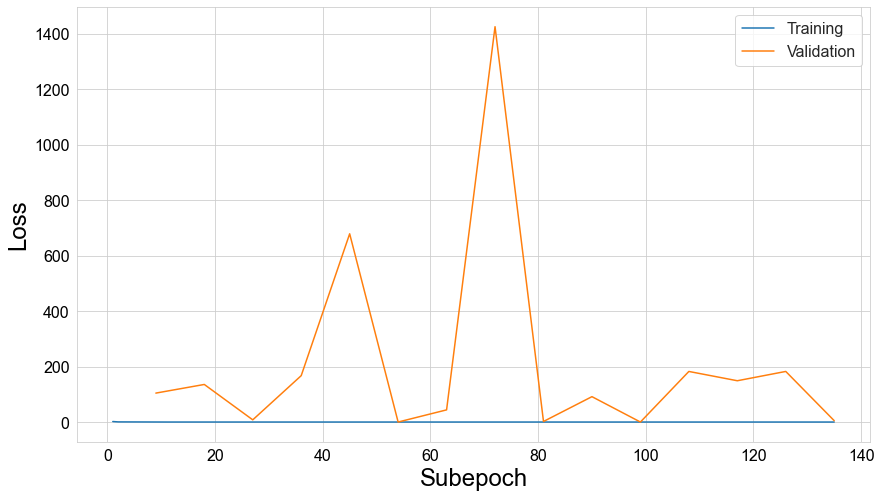

Mean loss = 0.6978845596313477±0.0
______________________________________



In [157]:
from lumin.nn.training.train import train_models
_ = train_models(sy, n_models=1,
                 model_builder=model_builder,
                 bs=32,
                 cb_partials=cb_partials,
                 n_epochs=15)

In [158]:
model = Model.from_save('train_weights/model_id_0/train_0.h5', model_builder)

In [159]:
data = sy[0]

In [160]:
pred = model.model(Tensor(data['inputs'][1]))

In [161]:
pred

tensor([[-0.6187, -0.7736],
        [-0.6189, -0.7734],
        [-0.6190, -0.7732],
        ...,
        [-0.7225, -0.6647],
        [-0.7224, -0.6647],
        [-0.7223, -0.6648]], grad_fn=<LogSoftmaxBackward>)

In [162]:
pred.argmax(-1).unique()

tensor([0, 1])

In [163]:
pred_class = pred.argmax(-1).numpy()

In [164]:
targs = data['targets'].flatten()

In [165]:
pred_class

array([0, 0, 0, ..., 1, 1, 1])

In [166]:
targs

array([0, 1, 1, ..., 0, 0, 0])

In [167]:
from sklearn.metrics import confusion_matrix

In [168]:
confusion_matrix(targs, pred_class)

array([[303, 314],
       [297, 286]])